# 0.05 `climpred` Verification

---

Now that that's all done, we can verify using `climpred`.

In [1]:
%load_ext lab_black

import cftime
import numpy as np
import xarray as xr
import climpred
import proplot as plot
import glob
from tqdm import tqdm
import dask.array as da

from dask.distributed import Client

In [2]:
climpred.__version__

'2.1.1'

In [3]:
client = Client("tcp://10.12.205.11:42722")

In [4]:
hind = xr.open_zarr(
    "/glade/scratch/rbrady/S2S/CESM1.S2S.tas_2m.anom.zarr/", consolidated=True
)
verif = xr.open_zarr("/glade/scratch/rbrady/S2S/ERA5.tas.zarr/", consolidated=True)

In [5]:
# spurious coordinate from the groupby operation
del hind["dayofyear"]

In [6]:
# the inits were in all weird order from loading in the files...
hind = hind.sortby("init").persist()

/glade/work/rbrady/miniconda3/envs/s2s/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [7]:
# converting to a proleptic gregorian calendar since the observations
# have leap years. you could also just drop the leap year days from
# the obs.
hind["init"] = [
    cftime.DatetimeProlepticGregorian(d.year, d.month, d.day)
    for d in hind["init"].values
]

# designate the lead time step unit.
hind["lead"].attrs["units"] = "days"

In [8]:
# Convert our verification product to the same calendar type.
# Climpred just needs to see the same datetime object styles for
# alignment. You could use numpy datestrings or pandas on both,
# cftime.noleap or gregorian, etc.
def convert_to_cftime(x):
    x = str(x)
    y, m, d = x.split("-")
    y = int(y)
    m = int(m)
    d = int(d.split("T")[0])
    return cftime.DatetimeProlepticGregorian(y, m, d)


verif["time"] = [convert_to_cftime(t) for t in verif.time.values]

In [9]:
# re-chunking since we need time and init to be one chunk for climpred operations.
verif = verif.chunk({"time": -1, "lat": "auto", "lon": "auto"}).persist()

In [10]:
# re-chunking hindcast to match the lat/lon chunks for performance.
hind = hind.chunk({"init": -1, "lead": "auto", "lat": 36, "lon": 72}).persist()

In [11]:
hindcast = climpred.HindcastEnsemble(hind).add_observations(verif)

## Verification

Starting out with just ten leads to make sure it runs okay.

In [12]:
result = hindcast.isel(init=slice(0, 10)).verify(
    metric="acc", comparison="e2o", dim="init", alignment="maximize"
)

In [13]:
%time result.compute()

CPU times: user 1.46 s, sys: 323 ms, total: 1.78 s
Wall time: 5.54 s


<xarray.Dataset>
Dimensions:  (lat: 181, lead: 45, lon: 360)
Coordinates:
  * lead     (lead) int64 0 1 2 3 4 5 6 7 8 9 ... 35 36 37 38 39 40 41 42 43 44
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
    skill    <U11 'initialized'
Data variables:
    TAS      (lead, lat, lon) float64 0.7105 0.7105 0.7105 ... 0.2949 0.2949

Now trying with all inits...

Still having `climpred` hang on building the `dask` graph for the verification (~40s), but computation proceeds in 6.17s which is great. That's with 887 inits, 45 leads and global 1x1 degree grid.

In [14]:
%time result = hindcast.verify(metric="acc", comparison="e2o", dim="init", alignment="maximize")

CPU times: user 40.2 s, sys: 39.1 ms, total: 40.3 s
Wall time: 40.4 s


In [15]:
%time result = result.compute()

CPU times: user 1.75 s, sys: 169 ms, total: 1.92 s
Wall time: 6.15 s


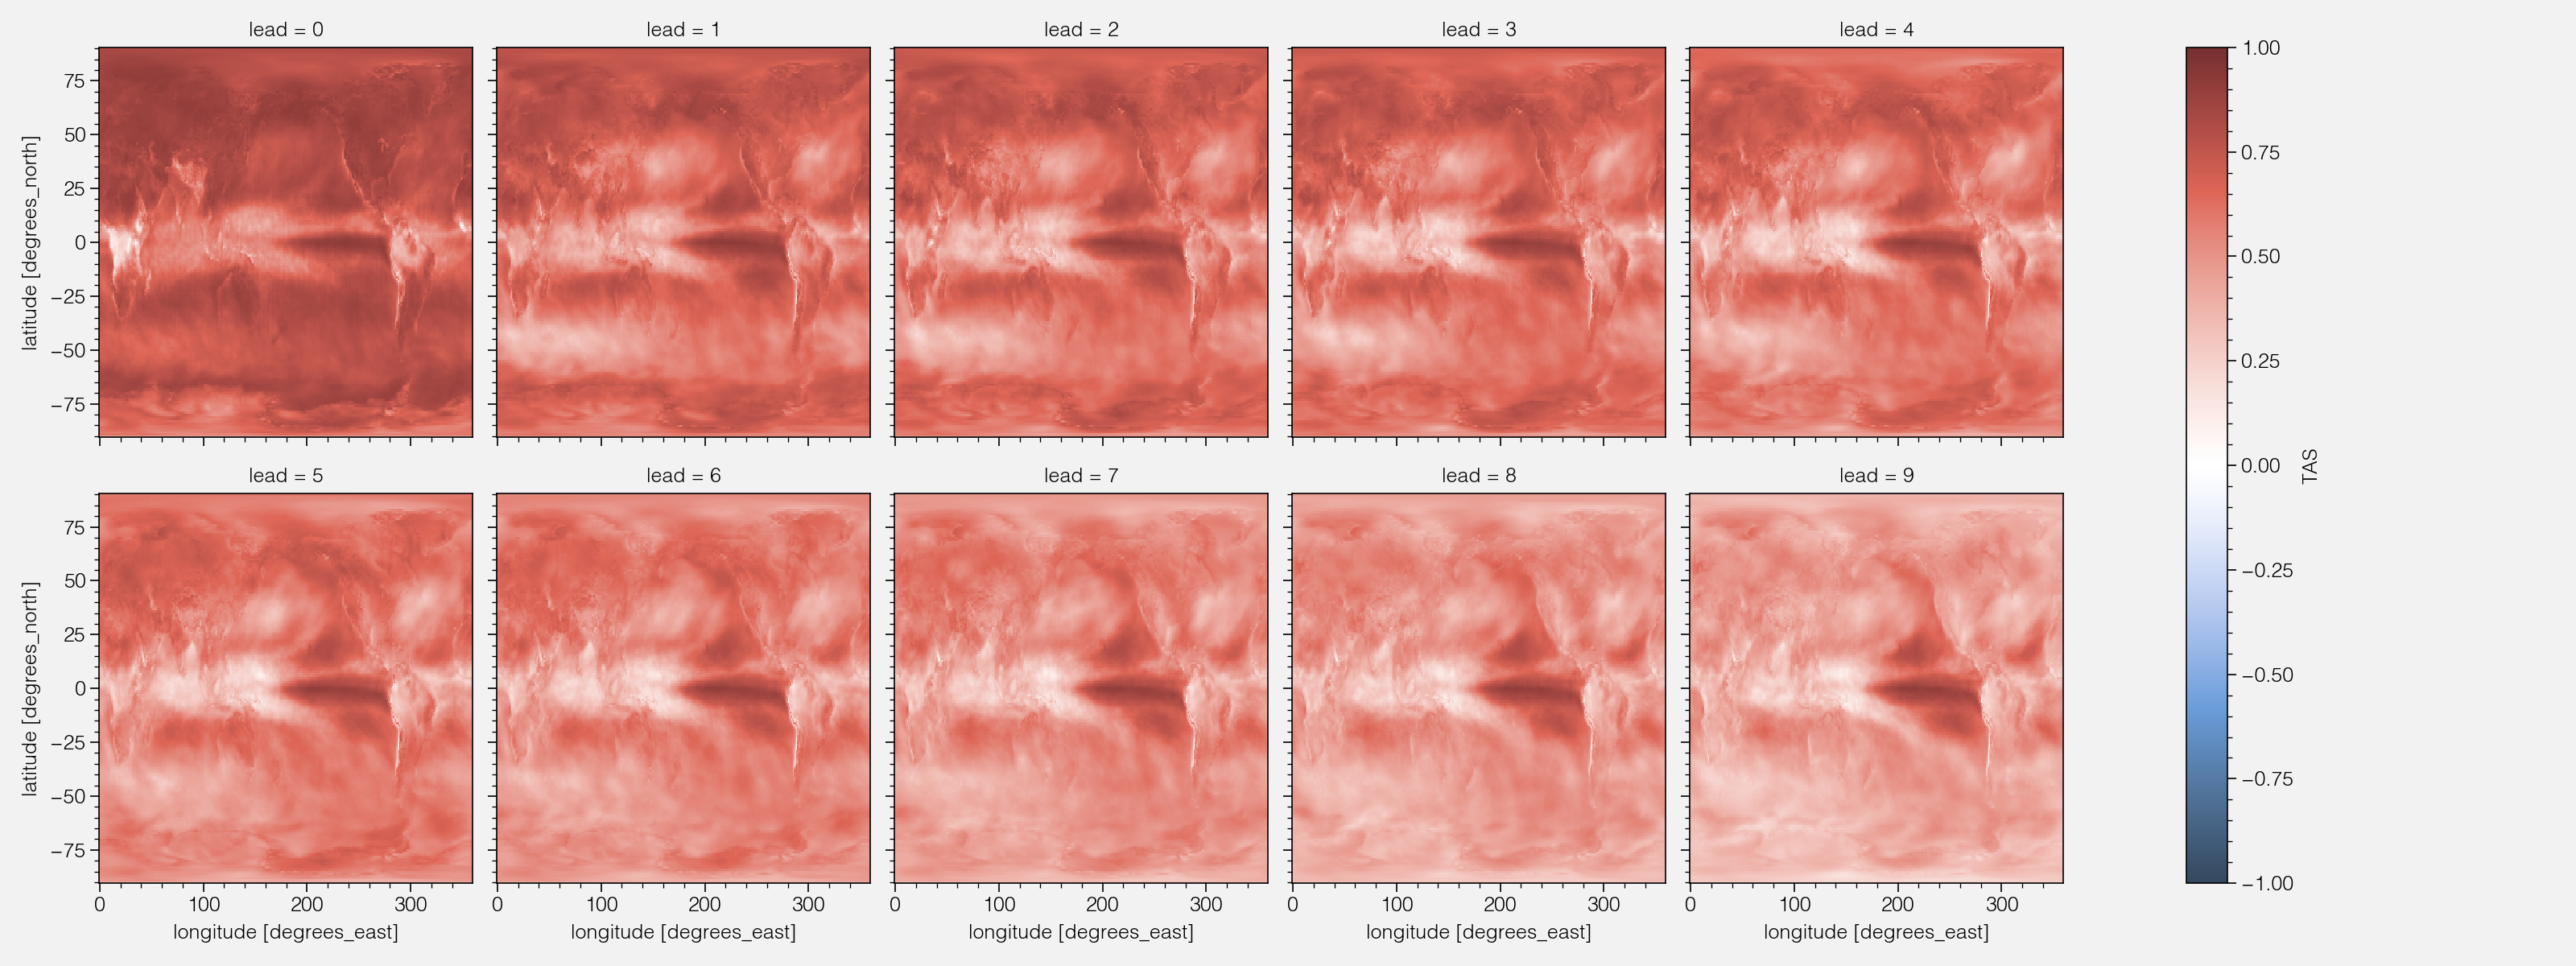

In [16]:
result.TAS.isel(lead=slice(0, 10)).plot(
    col="lead", vmin=-1, vmax=1, cmap="NegPos", col_wrap=5
)

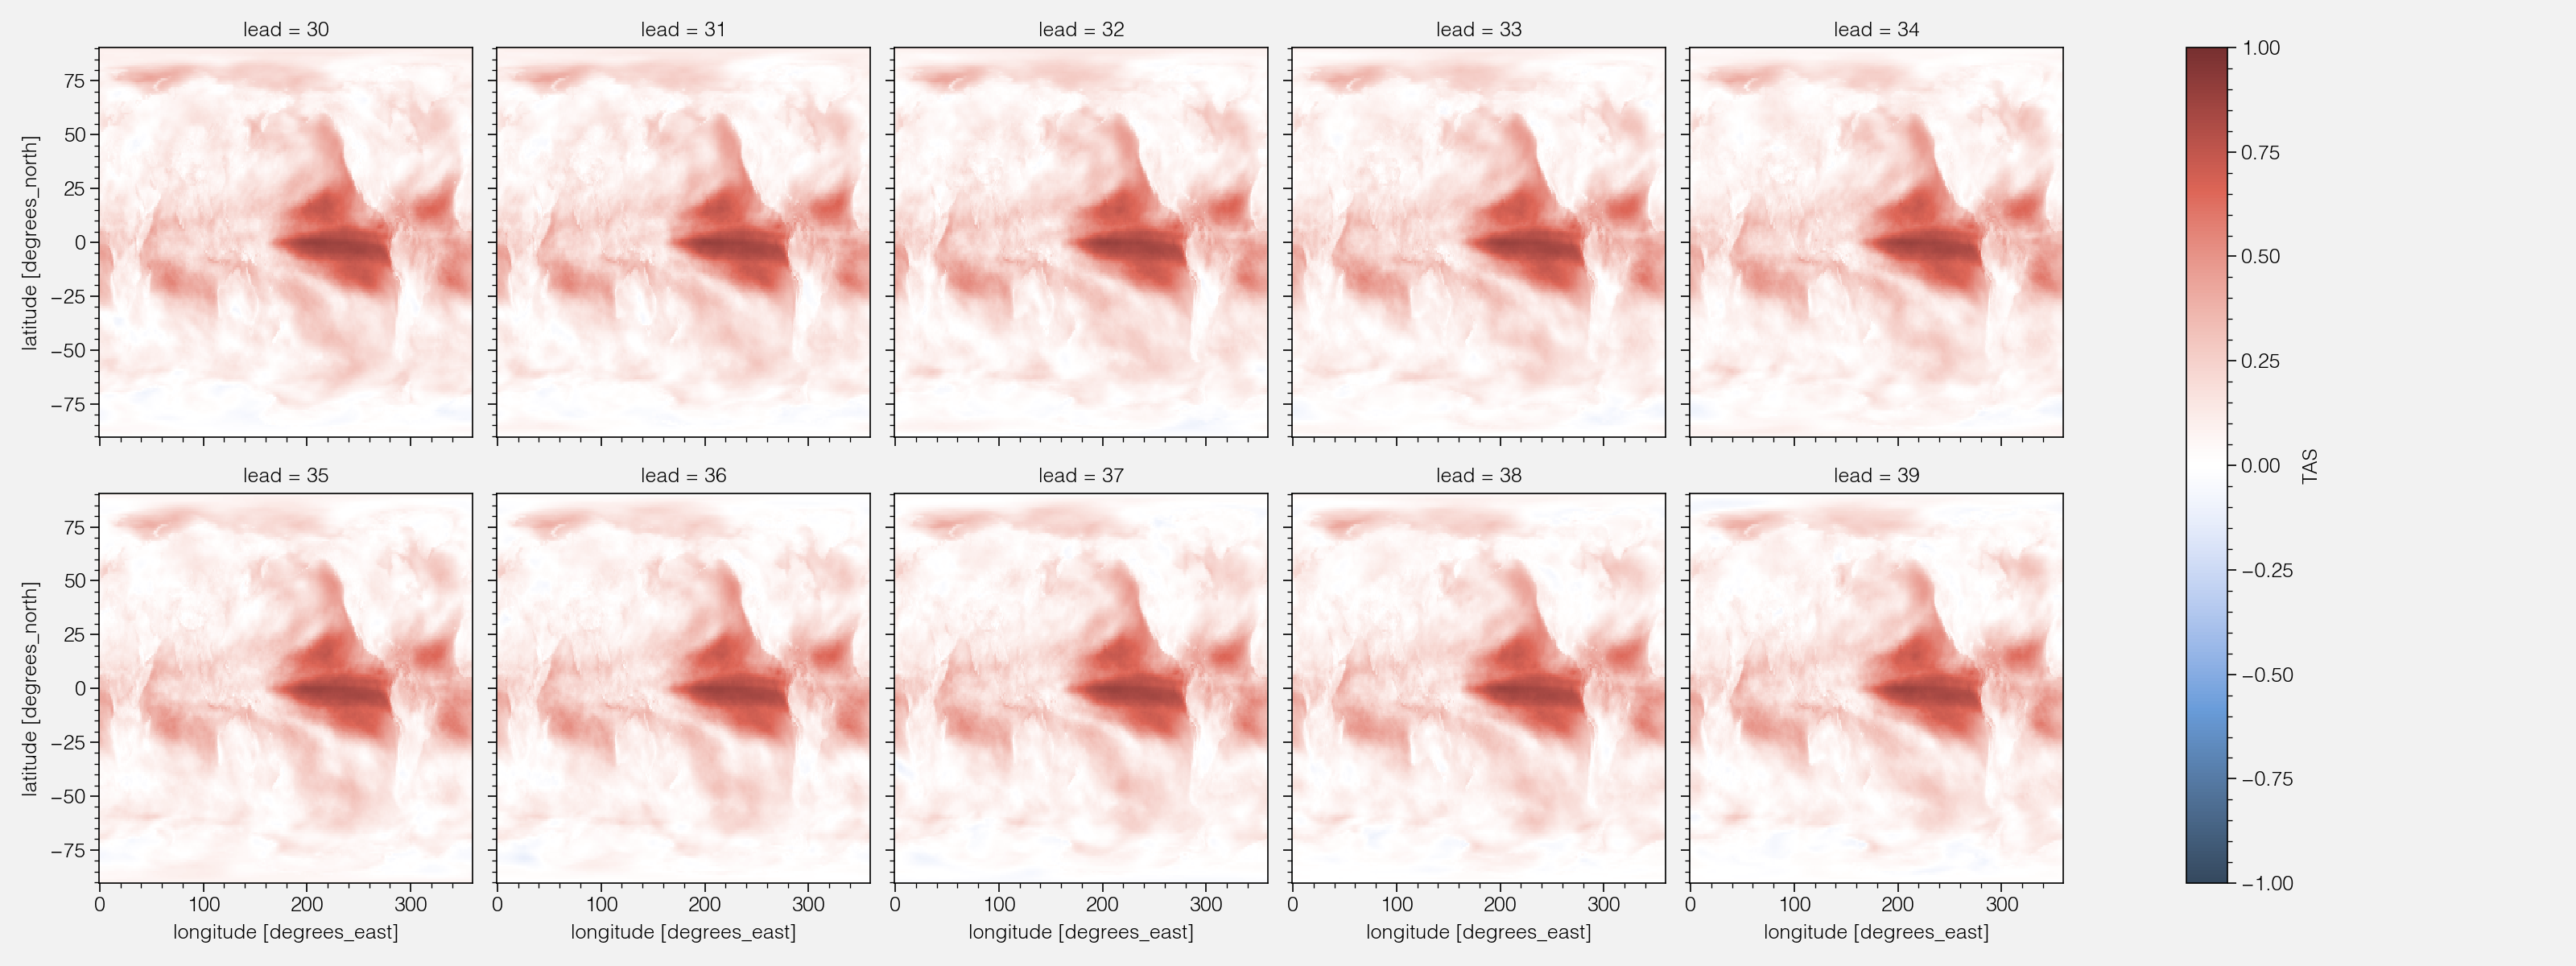

In [17]:
result.TAS.isel(lead=slice(30, 40)).plot(
    col="lead", vmin=-1, vmax=1, cmap="NegPos", col_wrap=5
)

We can of course use other metrics here.

In [18]:
%time result = hindcast.verify(metric="rmse", comparison="e2o", dim="init", alignment="maximize")

CPU times: user 39.6 s, sys: 19 ms, total: 39.6 s
Wall time: 39.7 s


In [19]:
%time result = result.compute()

CPU times: user 1.65 s, sys: 165 ms, total: 1.81 s
Wall time: 5.22 s


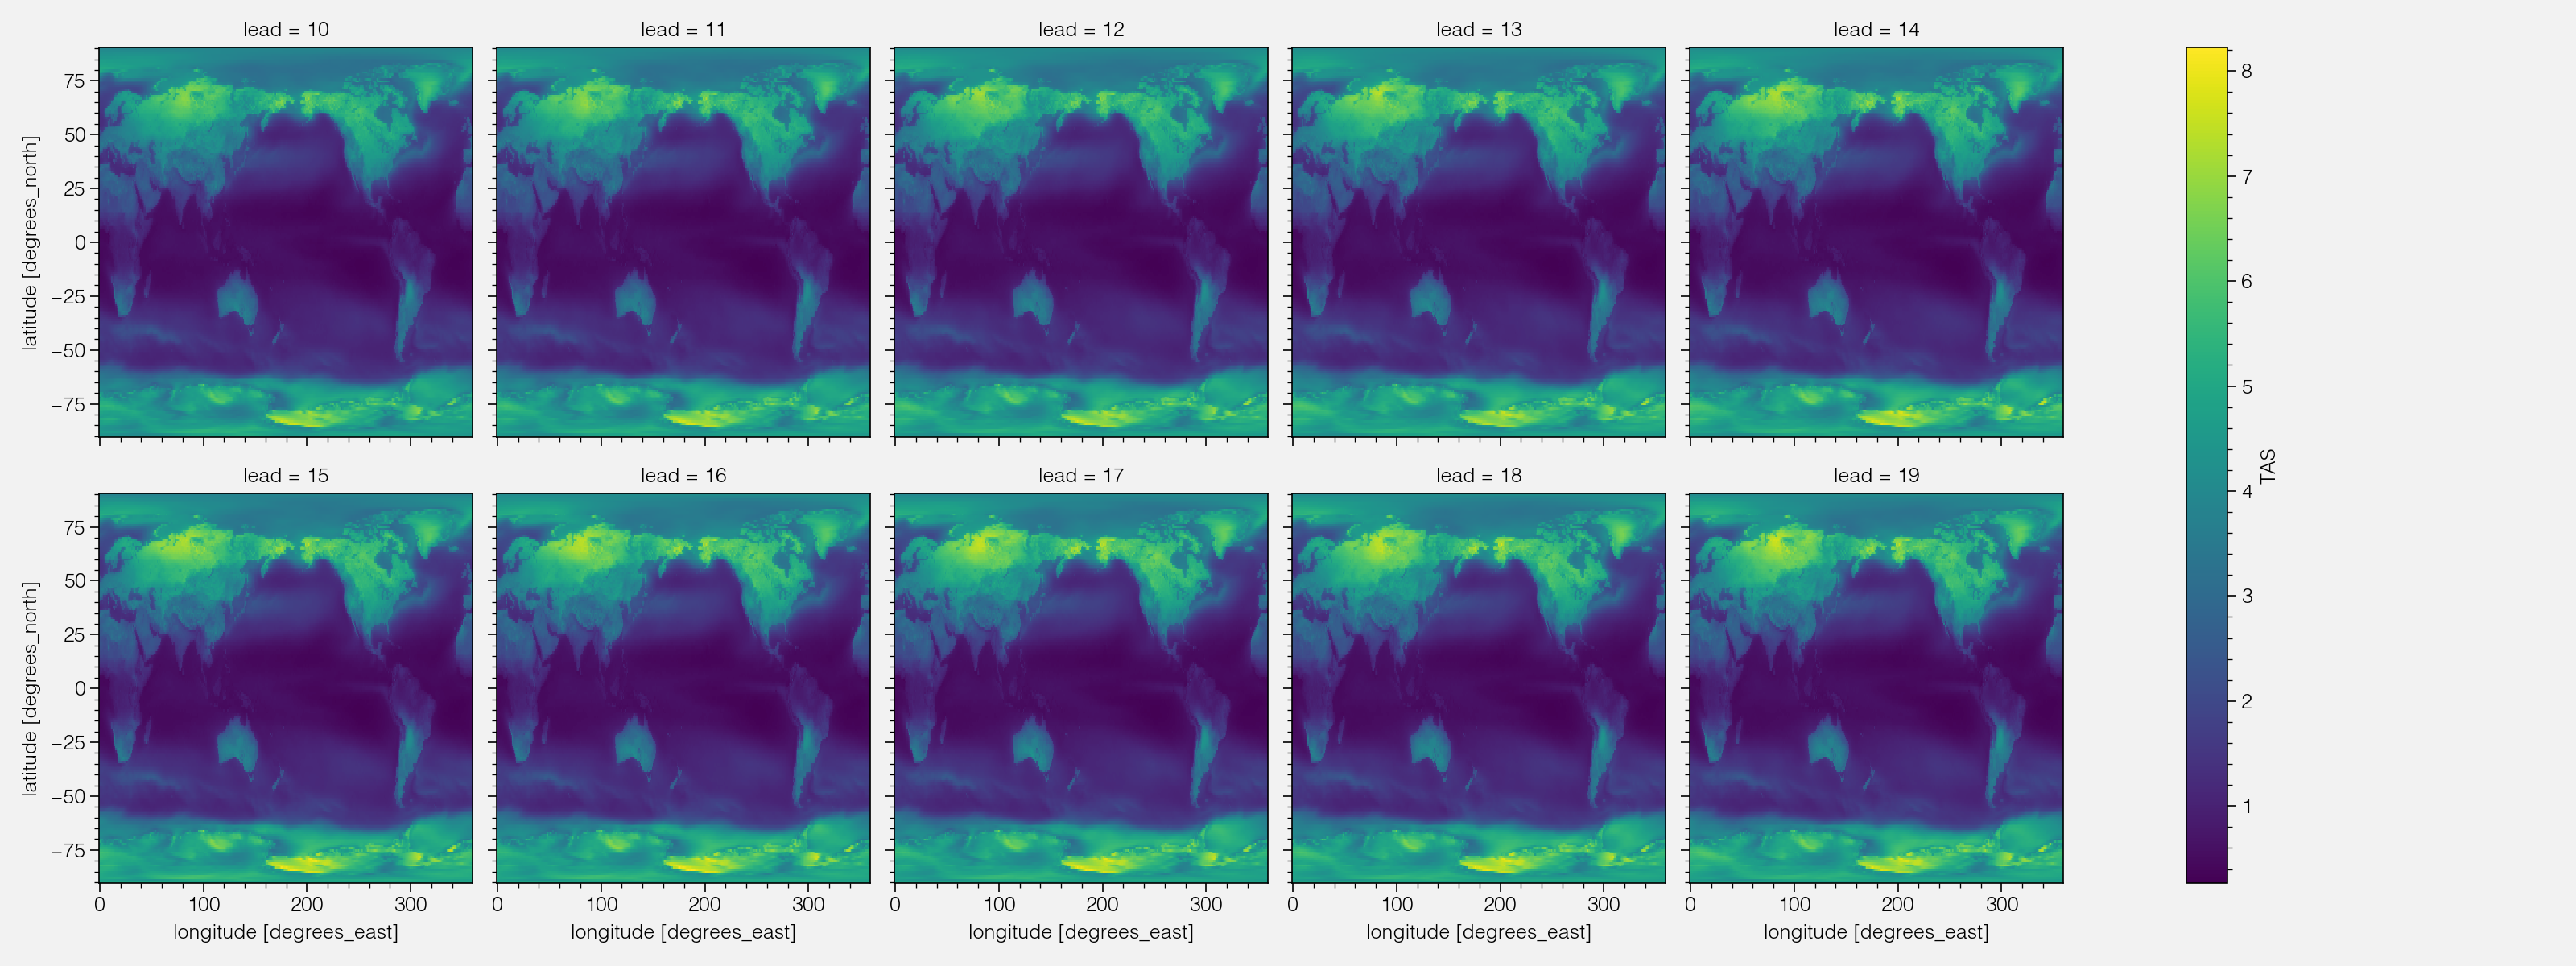

In [20]:
result.TAS.isel(lead=slice(10, 20)).plot(col="lead", col_wrap=5)

## Heatmap Grouped by Initialization Month

Another thought is that we can group this by initialization month. (This could be a useful addition to `climpred` as an automated feature...)

In [21]:
# Will do this with area-weighted global mean. Could of course do globally or by region, etc.
hind_aw = hind.weighted(np.cos(np.deg2rad(hind.lat))).mean(("lat", "lon")).persist()
verif_aw = verif.weighted(np.cos(np.deg2rad(verif.lat))).mean(("lat", "lon")).persist()

In [22]:
hindcast_aw = climpred.HindcastEnsemble(hind_aw).add_observations(verif_aw)

Again, it's this graph-building step that takes a long time. The actual verification is quite short once we have the dates figured out to align.

In [23]:
%time result = hindcast_aw.verify(metric='mae', comparison='e2o', dim='init', alignment='maximize')

CPU times: user 41 s, sys: 42.7 ms, total: 41.1 s
Wall time: 41.2 s


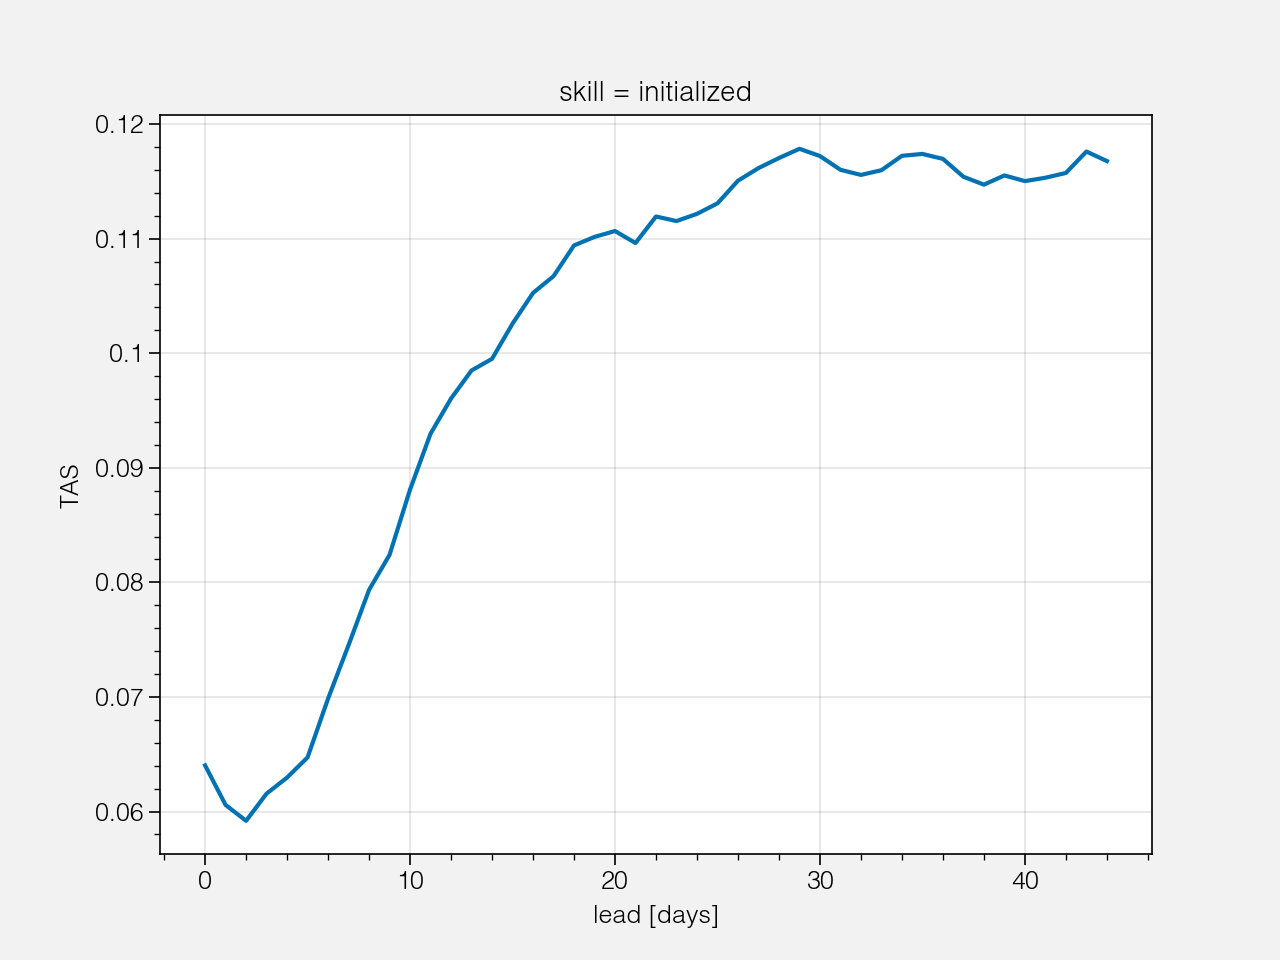

In [24]:
result.compute().TAS.plot()

This takes a bit of time (~2 minutes). I've discovered that the bottleneck is building the dictionary to align init dates with verif dates. We do this once up front, and it takes the same time to do this whether you have a high-res global grid or a single time series since the dates are equal at each grid cell.

In [25]:
results = []
# Loops through all inits for a given month.
for label, group in tqdm(hind_aw.groupby("init.month")):
    hindcast = climpred.HindcastEnsemble(group).add_observations(verif_aw)
    skill = hindcast.verify(
        metric="rmse",
        alignment="maximize",
        comparison="e2o",
        dim="init",
        reference="persistence",
    )
    results.append(skill)
results = xr.concat(results, dim="month")

100%|██████████| 12/12 [02:08<00:00, 10.69s/it]


In [26]:
results = results.TAS.load()

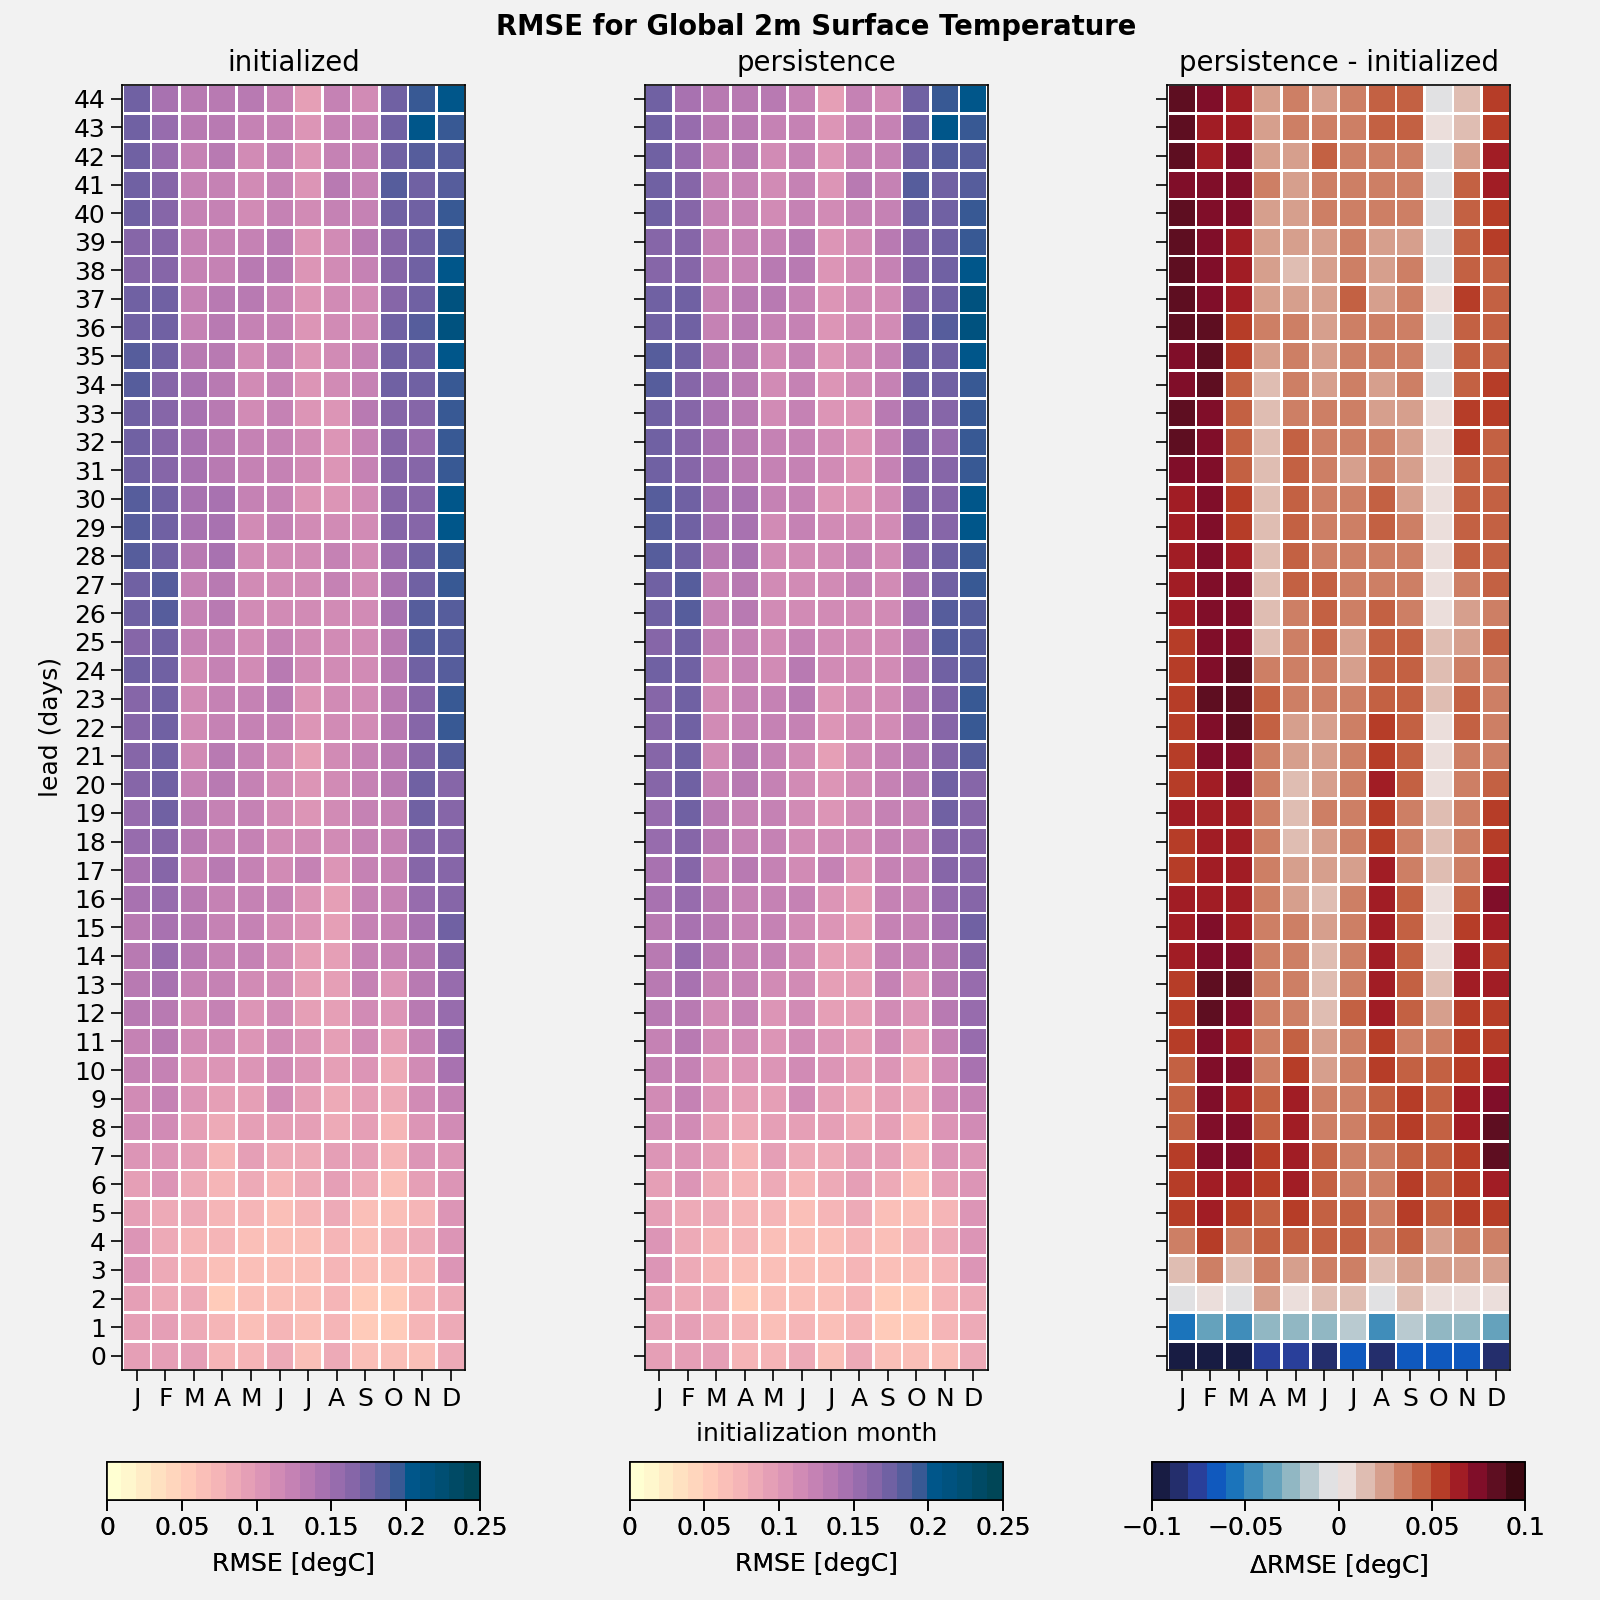

In [28]:
plot.rc.fontname = "Helvetica"

f, axs = plot.subplots(ncols=3, figsize=(8, 8))

res1 = results.sel(skill="initialized").transpose()
p1 = axs[0].heatmap(
    res1, edgecolor="w", levels=plot.arange(0, 0.25, 0.01), cmap="sunrise"
)
axs[0].colorbar(
    p1, loc="b", shrink=0.75, ticks=plot.arange(0, 0.25, 0.05), label="RMSE [degC]"
)
axs[0].format(title="initialized")

res2 = results.sel(skill="persistence").transpose()
p2 = axs[1].heatmap(
    res1, edgecolor="w", levels=plot.arange(0, 0.25, 0.01), cmap="sunrise"
)
axs[1].colorbar(
    p2, loc="b", shrink=0.75, ticks=plot.arange(0, 0.25, 0.05), label="RMSE [degC]"
)
axs[1].format(title="persistence")

res3 = res2 - res1
p3 = axs[2].heatmap(
    res3, edgecolor="w", levels=plot.arange(-0.1, 0.1, 0.01), cmap="Balance"
)
axs[2].colorbar(
    p3,
    loc="b",
    shrink=0.75,
    ticks=plot.arange(-0.1, 0.1, 0.05),
    label="$\Delta$RMSE [degC]",
)
axs[2].format(title="persistence - initialized")

axs.format(
    xtickloc="bottom",
    xlabel="initialization month",
    suptitle="RMSE for Global 2m Surface Temperature",
    xticklabels=["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"],
)